In [ ]:
# Description: This will scrape news from media outlets and create a graph with sentimental values for given tickers

In [ ]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [12]:
source = 'https://finviz.com/quote.ashx?t='
tickers = ['AAPL', 'AMD', 'PLTR']
news_tables = {}

for ticker in tickers:
  url = source + ticker
  req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
  response = urlopen(req)    
  # Read the contents of the file into 'html'
  html = BeautifulSoup(response)
  # Find 'news-table' in the Soup and load it into 'news_table'
  news_table = html.find(id='news-table')
  # Add the table to our dictionary
  news_tables[ticker] = news_table

In [13]:
# select number of days to analyze (No more than 3 days otherwise it's irrelavant)
day = 2
# Parse the news
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
  ticker = file_name.split('_')[0]
  count = 0
  # Iterate through all tr tags
  for tr in news_table.findAll('tr'):
    # The first tag contains date
    if len(tr.td.text.split()) > 1:
      date = tr.td.text.split()[0]
      time = tr.td.text.split()[1]
      count += 1
    else:
      time = tr.td.text.split()[0]

    if count <= day:
      parsed_news.append([file_name, date, time, tr.a.get_text()])
    else:
      break

In [14]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

df = pd.DataFrame(parsed_news, columns=['Ticker', 'Date', 'Time', 'Headline'])
# Apply Vader sentiment analysis to headlines
scores = df['Headline'].apply(vader.polarity_scores).tolist()
scores_df = pd.DataFrame(scores)
df = df.join(scores_df, rsuffix='_right')
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.set_index('Date', inplace=True)
df

,Ticker,Time,Headline,neg,neu,pos,compound
Date,,,,,,,
2021-02-18,AAPL,10:52PM,Dow Jones Futures: Stress Test Your Portfolio;...,0.157,0.843,0.000,-0.4215
2021-02-18,AAPL,07:30PM,Universal Electronics Inc (UEIC) Q4 2020 Earni...,0.000,1.000,0.000,0.0000
2021-02-18,AAPL,05:50PM,These Are The Best Robinhood Stocks To Buy Or ...,0.000,0.704,0.296,0.6369
2021-02-18,AAPL,05:39PM,Congress gets ready to grill Big Tech with a s...,0.000,0.839,0.161,0.3612
2021-02-18,AAPL,05:30PM,"Zuckerberg, Pichai, Dorsey Due Back for New Gr...",0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...
2021-02-17,PLTR,12:02PM,4 Palantir Analysts Debate Data Analytics Comp...,0.000,1.000,0.000,0.0000
2021-02-17,PLTR,10:12AM,"Benzinga's Top Ratings Upgrades, Downgrades Fo...",0.000,0.816,0.184,0.2023
2021-02-17,PLTR,08:45AM,"Palantir's Earnings Were Impressive, but the S...",0.000,0.823,0.177,0.2846


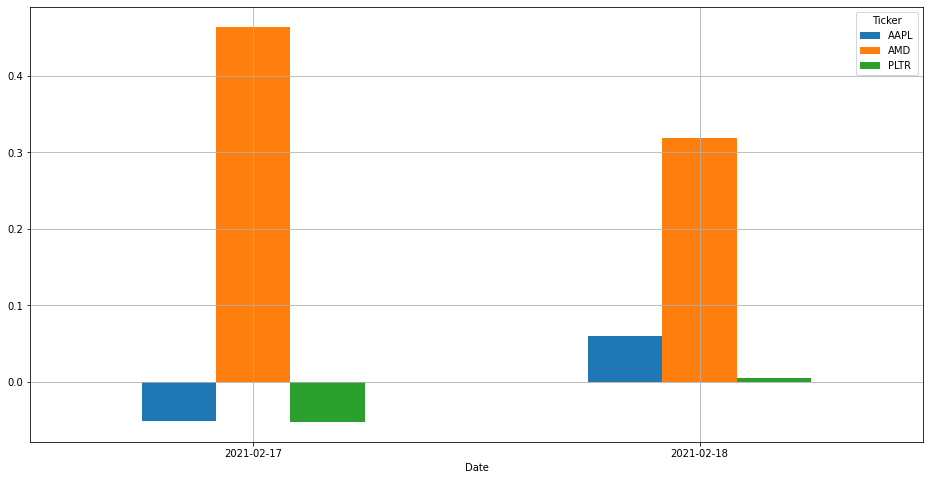

In [15]:
# Group the scores by ticker and date
mean_scores = df.groupby(['Ticker', 'Date']).mean()
mean_scores = mean_scores.unstack()
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar graph
plt.rcParams['figure.figsize'] = [16, 8]
mean_scores.plot.bar(rot=0)
plt.grid()

In [ ]:
# ====== ONLY RUN THIS IF YOU WANT TO READ INDIVIDUAL NEWS ======
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', len(df))
df